# Progetto di Machine Learning 2023

Il presente progetto riguarda la predizione dei prezzi delle case.

In [3]:
from feature_selection import *
from model_selection import *
from models import *
from grafici import *
from dataset import *
import pandas as pd
import numpy as np
import seaborn as sns

plots = Grafici()


# Preprocessing
Trasformiamo tutte le colonne categoriche in numeriche.
Se ci sono più di 5 possibili categorie, usiamo l'ordinal encoding
Altrimenti usiamo one-hot encoding (one-of-k)

In [4]:
from sklearn.model_selection import train_test_split


initial_training_set = pd.read_csv('../dataset/train.csv')

initial_X = initial_training_set.iloc[:, 1:-1] # tutte le colonne tranne l'ultima
initial_y = initial_training_set.iloc[:, -1] # solo l'ultima colonna

In [5]:
initial_training_set.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Suddividiamo il training e il testing set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(initial_X, initial_y, test_size=0.2, random_state=42)

print(f"shape train X: {X_train.shape}") 
print(f"shape train y: {y_train.shape}") 
print(f"shape test X: {X_test.shape}") 
print(f"shape test y: {y_test.shape}") 

shape train X: (1168, 79)
shape train y: (1168,)
shape test X: (292, 79)
shape test y: (292,)


Troviamo le colonne categoriche e numeriche

In [27]:
categorical_cols = initial_training_set.select_dtypes(include='object').columns.to_list()
categorical_train = initial_training_set[categorical_cols]
print(categorical_cols)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [28]:
numerical_cols = initial_training_set.select_dtypes(include='number').columns.to_list()
numerical_train = initial_training_set[numerical_cols]
print(numerical_cols)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


# Confronto features
Sono state confrontate tutte le feature con il target. Per i dettagli fare riferimento ai file dataset/valutazioneFeatures.csv e valutazioneFeatures.ipynb. Le feature più importanti sono le seguenti:

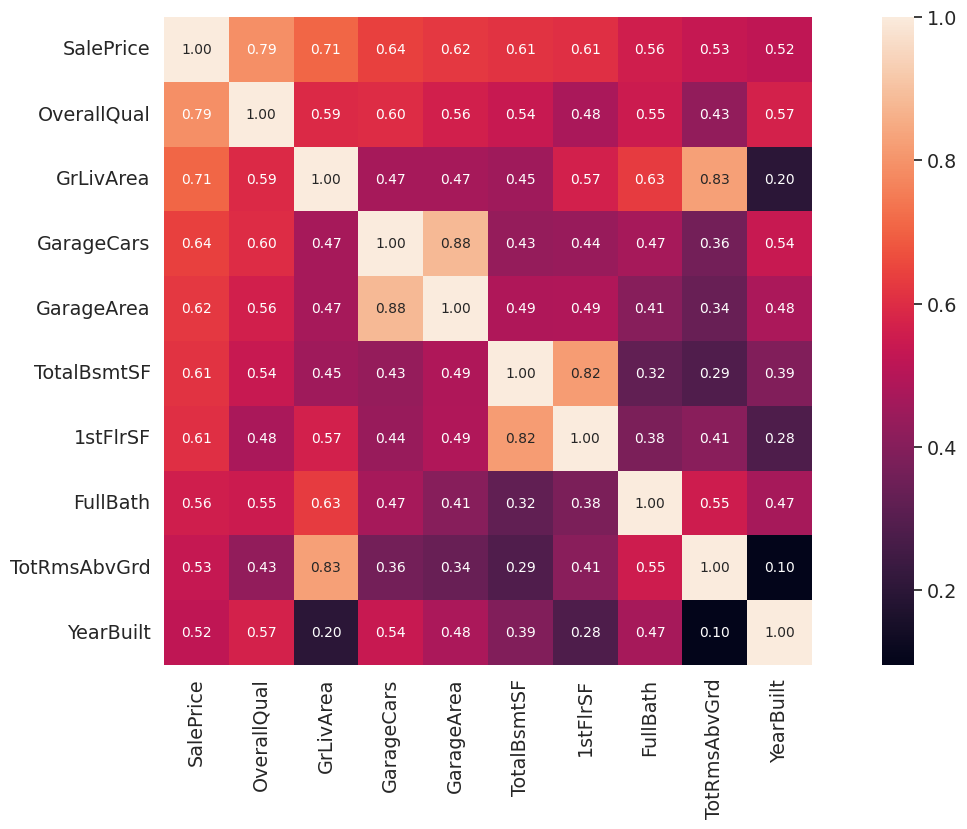

In [29]:
plots.correlation_matrix(numerical_train)

Analizziamo la heatmap:
- Sulla diagonale c'è sempre 1 perché le features sono in correlazione con loro stesse.
- La feature più importante è **OverallQual** con correlazione 0.79 rispetto al SalePrice.
- Garage Cars e Garage Area sono molto correlate tra loro, quindi si può mantenere solamente quella che è più correlata con il SalePrice, ovvero **GarageCars**.
- TotRmsAbvGrd e GrLivArea sono anche loro molto correlate tra loro, la più importante però è **GrLivArea**.
- 1stFlrSF è correlata con **TotalBsmtSF**, ma è più importante quest'ultima.